<a href="https://colab.research.google.com/github/Cheryleen5/Hate_Speech_Detection/blob/main/FINAL_LY_PROJECTipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [55]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dropout, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import load_model

In [56]:
df = pd.read_csv("/content/B.csv")

In [57]:
df.shape

(726119, 2)

In [58]:
df.head()

,Content,Label
0,denial of normal the con be asked to comment o...,1
1,just by being able to tweet this insufferable ...,1
2,that is retarded you too cute to be single tha...,1
3,thought of a real badass mongol style declarat...,1
4,afro american basho,1


Epoch 1/3
7942/7942 ━━━━━━━━━━━━━━━━━━━━ 116s 14ms/step - accuracy: 0.7718 - loss: 0.4660 - val_accuracy: 0.8285 - val_loss: 0.3717
Epoch 2/3
7942/7942 ━━━━━━━━━━━━━━━━━━━━ 147s 15ms/step - accuracy: 0.8266 - loss: 0.3761 - val_accuracy: 0.8406 - val_loss: 0.3491
Epoch 3/3
7942/7942 ━━━━━━━━━━━━━━━━━━━━ 133s 14ms/step - accuracy: 0.8392 - loss: 0.3536 - val_accuracy: 0.8366 - val_loss: 0.3625


6808/6808 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step


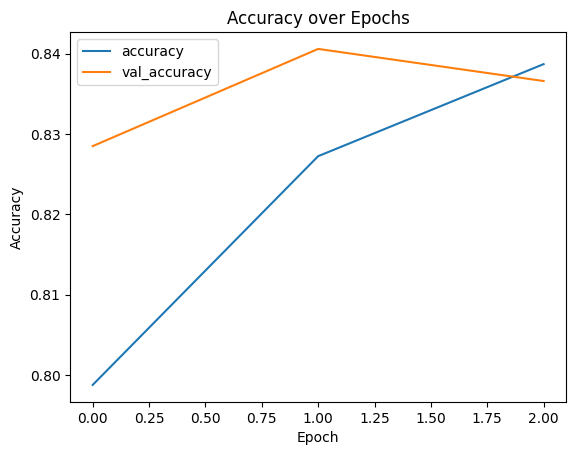

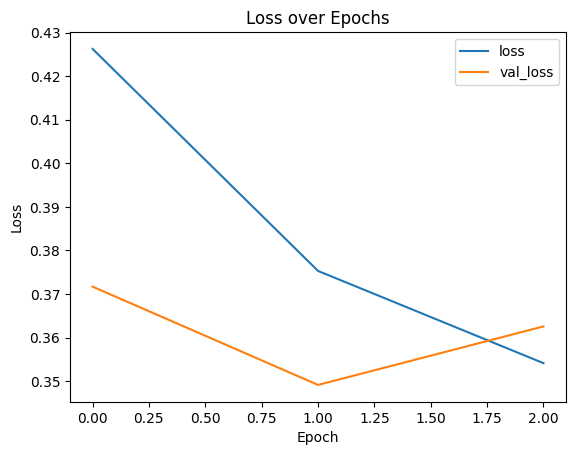

In [76]:
# Extract features and labels
x = df['Content']
y = df['Label']

# Ensure no NaN values after mapping
y = y.fillna(0).astype(int)

# Tokenization
max_features = 20000  # Vocabulary size
max_text_length = 400  # Max length of each comment

x_tokenizer = Tokenizer(num_words=max_features)
x_tokenizer.fit_on_texts(list(x))
x_tokenized = x_tokenizer.texts_to_sequences(x)
x_padded = pad_sequences(x_tokenized, maxlen=max_text_length)

# Split data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_padded, y, test_size=0.3, random_state=1)

# Load pre-trained GloVe embeddings
embedding_dim = 100
embeddings_index = {}
f = open('/content/glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

# Create embedding matrix
embedding_matrix = np.zeros((max_features, embedding_dim))
for word, index in x_tokenizer.word_index.items():
    if index > max_features - 1:
        break
    else:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector

# Build CNN model
filters = 250
kernel_size = 3
hidden_dims = 250

model = Sequential()
model.add(Embedding(max_features,
                    embedding_dim,
                    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                    trainable=False))

model.add(Dropout(0.2))
model.add(Conv1D(filters, kernel_size, padding='valid', activation='relu'))
model.add(MaxPooling1D())
model.add(Conv1D(filters, 5, padding='valid', activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(hidden_dims, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
batch_size = 64
epochs = 3
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(x_val, y_val))

# Save the model
model.save('/content/hate_speech_model.h5')  # Save the model here

# Evaluation
y_val_pred_prob = model.predict(x_val)
y_val_pred = (y_val_pred_prob >= 0.85).astype(int)

# Plotting Accuracy and Loss
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.show()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)              │ (None, 400, 100)            │       2,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 400, 100)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_8 (Conv1D)                    │ (None, 398, 250)            │          75,250 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_4 (MaxPooling1D)       │ (None, 199, 250)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_9 (Conv1D)                    │ (None, 195, 250)            │         312,750 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_4               │ (None, 250)                 │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 250)                 │          62,750 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 250)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │             251 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,451,003 (9.35 MB)

 Trainable params: 451,001 (1.72 MB)

 Non-trainable params: 2,000,000 (7.63 MB)

 Optimizer params: 2 (12.00 B)

6808/6808 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - accuracy: 0.8377 - loss: 0.3608
Overall validation accuracy: 83.66%
6808/6808 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step


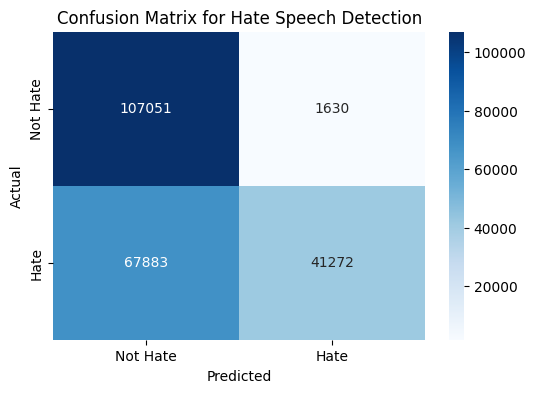

              precision    recall  f1-score   support

    Not Hate       0.61      0.99      0.75    108681
        Hate       0.96      0.38      0.54    109155

    accuracy                           0.68    217836
   macro avg       0.79      0.68      0.65    217836
weighted avg       0.79      0.68      0.65    217836



In [77]:
# Load the saved model
model = load_model('/content/hate_speech_model.h5')
model.summary()
# Assuming x_val and y_val are already defined and preprocessed
# Evaluate the loaded model
val_loss, val_accuracy = model.evaluate(x_val, y_val, verbose=1)

# Print overall accuracy
print(f"Overall validation accuracy: {val_accuracy * 100:.2f}%")

# Make predictions on validation data
y_val_pred_prob = model.predict(x_val)
y_val_pred = (y_val_pred_prob >= 0.85).astype(int)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_val, y_val_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Hate', 'Hate'], yticklabels=['Not Hate', 'Hate'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Hate Speech Detection')
plt.show()

# Optional: print classification report for more details
print(classification_report(y_val, y_val_pred, target_names=['Not Hate', 'Hate']))

In [79]:
# New sentences to check (some hate, some non-hate)
new_sentences = [
"I can't believe how amazing the community has become. Everyone is so supportive!",
"This group of people doesn't deserve any respect. They're ruining everything.",
"I love the way people are coming together to help each other!",
"You don't belong here. Why don't you just leave and never come back?",
"Helping others is what makes the world a better place.",
"These idiots should be banned from everywhere. They are a disgrace.",
"It’s inspiring to see people from all backgrounds working together for a good cause.",
"You're nothing but a loser, and no one cares about you!",
"Let’s keep spreading kindness and understanding, that’s what the world needs.",
"All they ever do is complain and whine. Just get rid of them already."
]

# Tokenize the new sentences using the tokenizer created earlier
new_sentences_tokenized = x_tokenizer.texts_to_sequences(new_sentences)

# Pad the sequences to the same length as the training data
new_sentences_padded = pad_sequences(new_sentences_tokenized, maxlen=max_text_length)

# Use the trained model to make predictions
new_predictions_prob = model.predict(new_sentences_padded)

# Convert predictions to binary classes (0 = not hate, 1 = hate) based on a threshold (0.85)
new_predictions = (new_predictions_prob >= 0.85).astype(int)

# Print the predictions
for i, sentence in enumerate(new_sentences):
    prediction = "Hate" if new_predictions[i] == 1 else "Not Hate"
    print(f"Sentence: '{sentence}' --> Prediction: {prediction}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Sentence: 'I can't believe how amazing the community has become. Everyone is so supportive!' --> Prediction: Not Hate
Sentence: 'This group of people doesn't deserve any respect. They're ruining everything.' --> Prediction: Not Hate
Sentence: 'I love the way people are coming together to help each other!' --> Prediction: Not Hate
Sentence: 'You don't belong here. Why don't you just leave and never come back?' --> Prediction: Hate
Sentence: 'Helping others is what makes the world a better place.' --> Prediction: Not Hate
Sentence: 'These idiots should be banned from everywhere. They are a disgrace.' --> Prediction: Hate
Sentence: 'It’s inspiring to see people from all backgrounds working together for a good cause.' --> Prediction: Not Hate
Sentence: 'You're nothing but a loser, and no one cares about you!' --> Prediction: Not Hate
Sentence: 'Let’s keep spreading kindness and understanding, that’s what the world needs.' --> Prediction: Not Hate
Sente